In [1]:
# 7.2.1 RNNCell

In [2]:
import torch
import torchtext
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time

In [3]:
start=time.time()
TEXT = torchtext.legacy.data.Field(lower=True, fix_length=200, batch_first=False)
LABEL = torchtext.legacy.data.Field(sequential=False)

In [4]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|█████████████████████████████████████████████████████████████████████████████| 84.1M/84.1M [00:38<00:00, 2.21MB/s]


In [5]:
print(vars(train_data.examples[0]))

{'text': ['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"teachers".', 'my', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', "high's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"teachers".', 'the', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students.', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'i', 'immediately', 'recalled', '.........', 'at', '..........', 'high.', 'a', 'classic', 'line:', 'inspector:', "i'm", 'here', 'to', 'sack', 'one', 'of', '

In [6]:
import string

for example in train_data.examples:
    text = [x.lower() for x in vars(example)['text']] 
    text = [x.replace("<br","") for x in text] 
    text = [''.join(c for c in s if c not in string.punctuation) for s in text] 
    text = [s for s in text if s] 
    vars(example)['text'] = text

In [7]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(0), split_ratio=0.8)

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


In [9]:
TEXT.build_vocab(train_data, max_size=10000, min_freq=10, vectors=None)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")


Unique tokens in TEXT vocabulary: 10002
Unique tokens in LABEL vocabulary: 3


In [10]:
print(LABEL.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x00000199F63B6610>>, {'<unk>': 0, 'pos': 1, 'neg': 2})


In [11]:
BATCH_SIZE = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

embeding_dim = 100
hidden_size = 300

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [12]:
class RNNCell_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNNCell_Encoder, self).__init__()
        self.rnn = nn.RNNCell(input_dim, hidden_size)

    def forward(self, inputs):
        bz = inputs.shape[1]
        ht = torch.zeros((bz, hidden_size)).to(device)

        for word in inputs:
            ht = self.rnn(word, ht)
        return ht

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.em = nn.Embedding(len(TEXT.vocab.stoi), embeding_dim)
        self.rnn = RNNCell_Encoder(embeding_dim, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.em(x)
        x = self.rnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
def training(epoch, model, trainloader, validloader):
    correct = 0
    total = 0
    running_loss = 0

    model.train()
    for b in trainloader:
        x, y = b.text, b.label
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total

    valid_correct = 0
    valid_total = 0
    valid_running_loss = 0

    model.eval()
    with torch.no_grad():
        for b in validloader:
            x, y = b.text, b.label
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            valid_correct += (y_pred == y).sum().item()
            valid_total += y.size(0)
            valid_running_loss += loss.item()

    epoch_valid_loss = valid_running_loss / len(validloader.dataset)
    epoch_valid_acc = valid_correct / valid_total

    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'valid_loss： ', round(epoch_valid_loss, 3),
          'valid_accuracy:', round(epoch_valid_acc, 3)
          )

    return epoch_loss, epoch_acc, epoch_valid_loss, epoch_valid_acc

In [15]:
epochs = 5
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_valid_loss, epoch_valid_acc = training(epoch,
                                                                 model,                                                                 train_iterator,                                                                 valid_iterator)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_acc)

end = time.time()
print(end-start)

epoch:  0 loss：  0.011 accuracy: 0.495 valid_loss：  0.011 valid_accuracy: 0.506
epoch:  1 loss：  0.011 accuracy: 0.505 valid_loss：  0.011 valid_accuracy: 0.5
epoch:  2 loss：  0.011 accuracy: 0.513 valid_loss：  0.011 valid_accuracy: 0.496
epoch:  3 loss：  0.011 accuracy: 0.518 valid_loss：  0.011 valid_accuracy: 0.499
epoch:  4 loss：  0.011 accuracy: 0.527 valid_loss：  0.011 valid_accuracy: 0.513
4176.316887378693


In [16]:
def evaluate(epoch, model, testloader):    
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    
    model.eval()
    with torch.no_grad():
        for b in testloader:
            x, y = b.text, b.label
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total

    print('epoch: ', epoch,
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
          )

    return epoch_test_loss, epoch_test_acc

In [17]:
epochs = 5

test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_test_loss, epoch_test_acc = evaluate(epoch,
                                               model,
                                               test_iterator)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

end = time.time()
print(end-start)

epoch:  0 test_loss：  0.011 test_accuracy: 0.501
epoch:  1 test_loss：  0.011 test_accuracy: 0.501
epoch:  2 test_loss：  0.011 test_accuracy: 0.501
epoch:  3 test_loss：  0.011 test_accuracy: 0.501
epoch:  4 test_loss：  0.011 test_accuracy: 0.501
4427.184522151947


In [18]:
# 7.2.2. RNN

In [19]:
import torch
import torchtext
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time

In [20]:
start=time.time()

TEXT = torchtext.legacy.data.Field(sequential = True, batch_first = True, lower = True)
LABEL = torchtext.legacy.data.Field(sequential = False, batch_first = True) 

from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(split_ratio = 0.8)

TEXT.build_vocab(train_data, max_size=10000, min_freq=10, vectors=None)
LABEL.build_vocab(train_data)

BATCH_SIZE = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [22]:
vocab_size = len(TEXT.vocab)
n_classes = 2  

In [23]:
class BasicRNN(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p = 0.2):
        super(BasicRNN, self).__init__()
        self.n_layers = n_layers 
        self.embed = nn.Embedding(n_vocab, embed_dim) 
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.rnn = nn.RNN(embed_dim, self.hidden_dim, num_layers = self.n_layers, batch_first = True) 
        self.out = nn.Linear(self.hidden_dim, n_classes) 

    def forward(self, x):
        x = self.embed(x) 
        h_0 = self._init_state(batch_size = x.size(0)) 
        x, _ = self.rnn(x, h_0) 
        h_t = x[:, -1, :] 
        self.dropout(h_t)
        logit = torch.sigmoid(self.out(h_t))
        return logit

    def _init_state(self, batch_size = 1):
        weight = next(self.parameters()).data 
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [24]:
model = BasicRNN(n_layers = 1, hidden_dim = 256, n_vocab = vocab_size, embed_dim = 128, n_classes = n_classes, dropout_p = 0.5)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1)
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

        if b % 50 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(e,
                                                                           b * len(x),
                                                                           len(train_iter.dataset),
                                                                           100. * b / len(train_iter),
                                                                           loss.item()))

In [26]:
def evaluate(model, val_iter):
    model.eval()
    corrects, total, total_loss = 0, 0, 0

    for batch in val_iter:
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1) 
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction = "sum")
        total += y.size(0)
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
        
    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [27]:
BATCH_SIZE = 100
LR = 0.001
EPOCHS = 5
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
for e in range(1, EPOCHS + 1):
    train(model, optimizer, train_iterator)
    val_loss, val_accuracy = evaluate(model, valid_iterator)
    print("[EPOCH: %d], Validation Loss: %5.2f | Validation Accuracy: %5.2f" % (e, val_loss, val_accuracy))

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.699812
Train Epoch: 1 [5000/20000 (25%)]	Loss: 0.694306
Train Epoch: 1 [10000/20000 (50%)]	Loss: 0.693836
Train Epoch: 1 [15000/20000 (75%)]	Loss: 0.693642
[EPOCH: 1], Validation Loss:  0.69 | Validation Accuracy:  0.52
Train Epoch: 2 [0/20000 (0%)]	Loss: 0.693216
Train Epoch: 2 [5000/20000 (25%)]	Loss: 0.693132
Train Epoch: 2 [10000/20000 (50%)]	Loss: 0.693074
Train Epoch: 2 [15000/20000 (75%)]	Loss: 0.691989
[EPOCH: 2], Validation Loss:  0.70 | Validation Accuracy:  0.50
Train Epoch: 3 [0/20000 (0%)]	Loss: 0.692737
Train Epoch: 3 [5000/20000 (25%)]	Loss: 0.695586
Train Epoch: 3 [10000/20000 (50%)]	Loss: 0.691363
Train Epoch: 3 [15000/20000 (75%)]	Loss: 0.692181
[EPOCH: 3], Validation Loss:  0.69 | Validation Accuracy:  0.51
Train Epoch: 4 [0/20000 (0%)]	Loss: 0.691303
Train Epoch: 4 [5000/20000 (25%)]	Loss: 0.692768
Train Epoch: 4 [10000/20000 (50%)]	Loss: 0.694786
Train Epoch: 4 [15000/20000 (75%)]	Loss: 0.692846
[EPOCH: 4], Validation Loss:  0.

In [28]:
test_loss, test_acc = evaluate(model,test_iterator)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.69 | Test Accuracy:  0.60


In [29]:
# 7.3.2 LSTMCell

In [30]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [31]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

In [33]:
from torchvision.datasets import MNIST

download_root = 'e:/torch/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [34]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

valid_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

In [35]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [36]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):        
        hx, cx = hidden        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)    
        gates = gates.squeeze()        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        
        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)        
        hy = torch.mul(outgate, F.tanh(cy))        
        return (hy, cy)

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
         
        self.layer_dim = layer_dim               
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)          
        self.fc = nn.Linear(hidden_dim, output_dim)
         
    def forward(self, x):        
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))
                           
        outs = []        
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
            outs.append(hn)
                
        out = outs[-1].squeeze()        
        out = self.fc(out) 
        return out

In [38]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  
output_dim = 10
 
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [39]:
seq_dim = 28 

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):          
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0:         
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                 
                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

E:\anadonda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
E:\anadonda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500. Loss: 2.237457513809204. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 0.8156253695487976. Accuracy: 75.58000183105469
Iteration: 1500. Loss: 0.4442233443260193. Accuracy: 89.0199966430664
Iteration: 2000. Loss: 0.2941139340400696. Accuracy: 92.5199966430664
Iteration: 2500. Loss: 0.10072824358940125. Accuracy: 94.36000061035156
Iteration: 3000. Loss: 0.07324947416782379. Accuracy: 96.41000366210938
Iteration: 3500. Loss: 0.07463668286800385. Accuracy: 96.52999877929688
Iteration: 4000. Loss: 0.02473960630595684. Accuracy: 97.38999938964844
Iteration: 4500. Loss: 0.05208646133542061. Accuracy: 97.23999786376953
Iteration: 5000. Loss: 0.08925972133874893. Accuracy: 97.2300033569336
Iteration: 5500. Loss: 0.16396191716194153. Accuracy: 96.95999908447266
Iteration: 6000. Loss: 0.03904556855559349. Accuracy: 97.61000061035156
Iteration: 6500. Loss: 0.012450279667973518. Accuracy: 97.69999694824219
Iteration: 7000. Loss: 0.01861385628581047. Accuracy: 97.91999816894531

In [40]:
def evaluate(model, val_iter):    
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
                
        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [41]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.06 | Test Accuracy:  0.98


In [1]:
# 7.3.3 LSTM

In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data=pd.read_csv('e:/torch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data['Volume'] = data['Volume'].astype(float)

In [6]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [8]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [9]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [10]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [11]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors) 
    loss.backward() 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.09935
Epoch: 100, loss: 0.04244
Epoch: 200, loss: 0.03923
Epoch: 300, loss: 0.03838
Epoch: 400, loss: 0.03734
Epoch: 500, loss: 0.03573
Epoch: 600, loss: 0.03403
Epoch: 700, loss: 0.03233
Epoch: 800, loss: 0.03087
Epoch: 900, loss: 0.02950


In [12]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

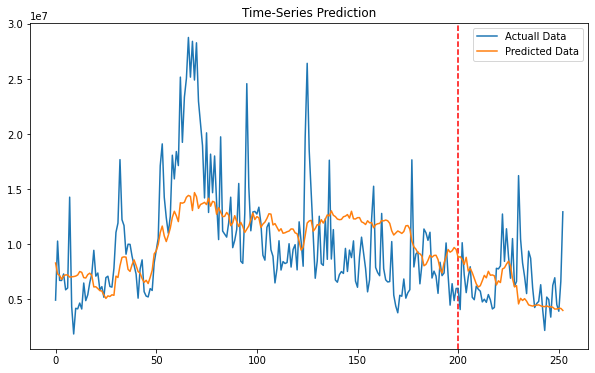

In [13]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actuall Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [14]:
# 7.4.2 GURCell

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [16]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

In [17]:
from torchvision.datasets import MNIST
download_root = 'e:/torch/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [18]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

valid_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

In [19]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [20]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
                
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)              
        return hy

In [21]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim               
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
                
        outs = []        
        hn = h0[0,:,:]
        
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn) 
            outs.append(hn)
            
        out = outs[-1].squeeze()        
        out = self.fc(out) 
        return out

In [22]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  
output_dim = 10
 
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
 
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
seq_dim = 28 

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):         
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0:         
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

E:\anadonda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
E:\anadonda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500. Loss: 1.661692500114441. Accuracy: 43.59000015258789
Iteration: 1000. Loss: 0.8945671319961548. Accuracy: 76.19999694824219
Iteration: 1500. Loss: 0.29147762060165405. Accuracy: 89.7300033569336
Iteration: 2000. Loss: 0.23627924919128418. Accuracy: 93.51000213623047
Iteration: 2500. Loss: 0.03288724273443222. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.030374949797987938. Accuracy: 95.81999969482422
Iteration: 3500. Loss: 0.16210567951202393. Accuracy: 96.33999633789062
Iteration: 4000. Loss: 0.1930878460407257. Accuracy: 96.19000244140625
Iteration: 4500. Loss: 0.05172012746334076. Accuracy: 97.0
Iteration: 5000. Loss: 0.1390017569065094. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.08090303093194962. Accuracy: 97.62000274658203
Iteration: 6000. Loss: 0.1048836037516594. Accuracy: 97.69000244140625
Iteration: 6500. Loss: 0.07984019815921783. Accuracy: 97.80000305175781
Iteration: 7000. Loss: 0.10250381380319595. Accuracy: 97.55999755859375
Iteration: 7

In [24]:
def evaluate(model, val_iter):    
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [25]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


In [26]:
# 7.4.3 GUR

In [27]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
data=pd.read_csv('e:/torch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [29]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [30]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [32]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [33]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        output, (hn) = self.gru(x, (h_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out

In [34]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [35]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors)
    loss.backward() 
 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.11692
Epoch: 100, loss: 0.04124
Epoch: 200, loss: 0.03291
Epoch: 300, loss: 0.03008
Epoch: 400, loss: 0.02830
Epoch: 500, loss: 0.02701
Epoch: 600, loss: 0.02590
Epoch: 700, loss: 0.02486
Epoch: 800, loss: 0.02385
Epoch: 900, loss: 0.02284


In [37]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

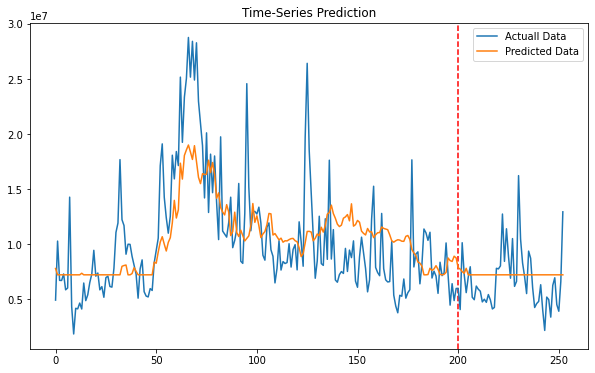

In [38]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actuall Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [39]:
# 7.6.2 양방향 LSTM

In [40]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [41]:
data=pd.read_csv('e:/torch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [42]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [43]:
data['Volume'] = data['Volume'].astype(float)

In [44]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [46]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [47]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=True, batch_first=True) 
        self.fc =  nn.Linear(hidden_size*2, num_classes) 
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))                 
        out, _ = self.lstm(x, (h_0, c_0)) 
        out = self.fc(out[:, -1, :])               
        out = self.relu(out)
        return out

In [48]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [49]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad() 
 
    loss = criterion(outputs, y_train_tensors) 
    loss.backward()  
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.04069
Epoch: 100, loss: 0.03687
Epoch: 200, loss: 0.03386
Epoch: 300, loss: 0.03143
Epoch: 400, loss: 0.02948
Epoch: 500, loss: 0.02797
Epoch: 600, loss: 0.02681
Epoch: 700, loss: 0.02592
Epoch: 800, loss: 0.02522
Epoch: 900, loss: 0.02466


In [51]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

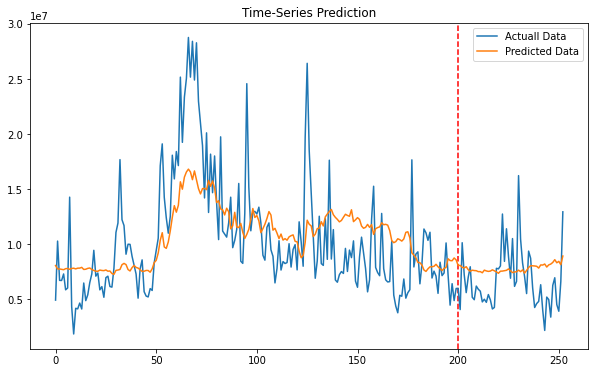

In [52]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actuall Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 